# Part 1: CNN building blocks

## Prerequisite
You will need to have several dependencies installed to run code listed here:
* numpy, pylab
* opencv2
* theano

First, we import all the functions that will be needed later on and define two simple plotting functions:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import theano.tensor as T
from theano.tensor.nnet import conv
from theano.tensor.signal import downsample
from theano import function
import numpy.random as random
import cv2

plt.rcParams['figure.figsize'] = (20.0, 5.0)

def plot(x):
    plt.imshow(x, interpolation='nearest')
    plt.axis('off')
    plt.show()
    
def plot_v(x):
    plt.gray()
    plt.imshow(np.hstack(x), interpolation='nearest')
    plt.axis('off')
    plt.show()

## Part 1.1: convolution

A feed-forward neural network can be thought of as the composition of number of functions 

\begin{equation}
f(\mathbf{x}) = f_L(\dots f_2(f_1(\mathbf x;\mathbf w_1);\mathbf w_2)\dots),\mathbf w_{L}).
\end{equation}

Each function $f_l$ takes as input a datum $\mathbf x_l$ and a parameter vector $\mathbf w_l$ and produces as output a datum $\mathbf x_{l+1}$. While the type and sequence of functions is usually handcrafted, the parameters $\mathbf w=(\mathbf w_1,…,\mathbf w_{L})$ are learned from data in order to solve a target problem, for example classifying images or sounds.

In a convolutional neural network data and functions have additional structure. The data $\mathbf x_1,…,\mathbf x_n$ are images, sounds, or more in general maps from a lattice1 to one or more real numbers. In particular, since the rest of the practical will focus on computer vision applications, data will be 2D arrays of pixels. Formally, each $\mathbf x_i$ will be a $M×N×K$ real array of $M×N$ pixels and $K$ channels per pixel. Hence the first two dimensions of the array span space, while the last one spans channels. Note that only the input $\mathbf x=\mathbf x_1$ of the network is an actual image, while the remaining data are intermediate feature maps.

The second property of a CNN is that the functions $f_l$ have a convolutional structure. This means that $f_l$ applies to the input map $\mathbf x_l$ an operator that is local and translation invariant. Examples of convolutional operators are applying a bank of linear filters to $\mathbf x_l$.

In this part we will familiarise ourselves with a number of such convolutional and non-linear operators. The first one is the regular linear convolution by a filter bank. We will start by focusing our attention on a single function relation as follows: 

\begin{equation}
f: \mathbb{R}^{M\times N\times K} \rightarrow \mathbb{R}^{M' \times N' \times K'},
\qquad \mathbf x \mapsto \mathbf y.
\end{equation}



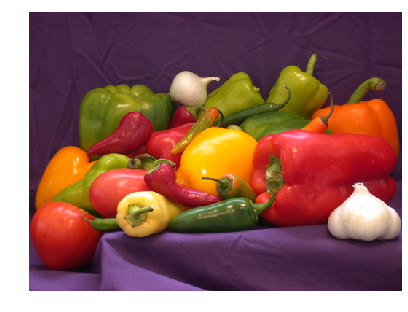

In [2]:
# Read an example image
x = cv2.imread('data/peppers.png')
x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
plot(x)

First we define a "proxy" function for the convolution that calls the more complex Theano ```conv2``` function.

In [3]:
# Define 2d filter bank function with Theano
def nnconv(stride=1, border_mode='valid'):
    _x = T.tensor4('input')
    filters = T.tensor4('filters')
    out = conv.conv2d(_x, filters, subsample=(stride, stride), border_mode=border_mode)
    return function([_x, filters], out)

Now we will create a bank 10 of 5×5×3 filters.

In [4]:
# Create a bank of linear filters
w = np.array(random.randn(10, 3, 5, 5), 'float32')

Note that w has four dimensions, packing 10 filters. Note also that each filter is not flat, but rather a volume with three layers. The next step is applying the filter to the image. This uses the ```nnconv``` function defined previously:

In [5]:
# Reshape input to 4d array with shape: (nb_images, nb_channels, w, h)
x4d = np.array(np.expand_dims(x.transpose((2, 0, 1)), axis=0), 'f')

# Apply the convolutional operator
y = nnconv()(x4d, w)

The variable $y$ contains the output of the convolution. Note that the filters are three-dimensional, in the sense that it operates on a map $\mathbf x$ with $K$ channels. Furthermore, there are $K′$ such filters, generating a $K′$ dimensional map $y$ as follows 

\begin{equation}
y_{i'j'k'} = \sum_{ijk} w_{ijkk'} x_{i+i',j+j',k}
\end{equation}

We can now visualise the output $y$ of the convolution. In order to do this, use the ```plot_v``` function to display an image for each feature channel in $y$:

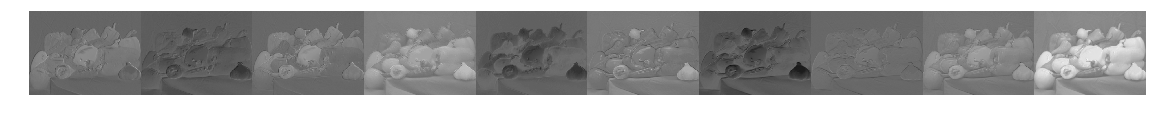

In [6]:
plot_v(y[0])

So far filters preserve the resolution of the input feature map. However, it is often useful to downsample the output. This can be obtained by using the stride option in ```nnconv```:

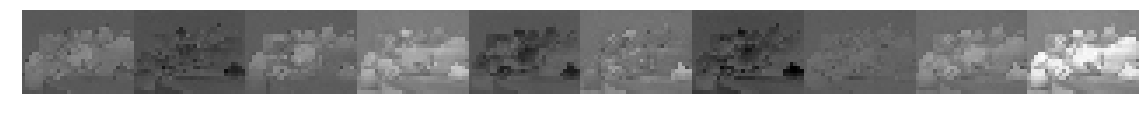

In [7]:
# Try again, downsampling the output
y_ds = nnconv(stride=16)(x4d, w)
plot_v(y_ds[0])

As you should have noticed in a question above, applying a filter to an image or feature map interacts with the boundaries, making the output map smaller by an amount proportional to the size of the filters. If this is undesirable, then the input array can be padded with zeros by using the pad option:

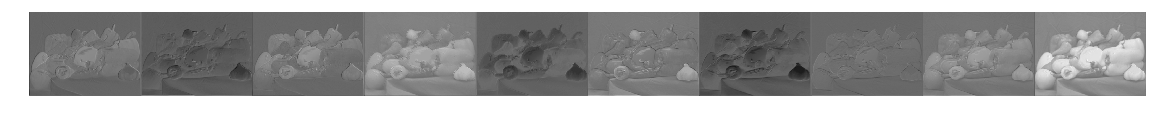

In [8]:
# Try padding
y_pad = nnconv(border_mode='full')(x4d, w)
plot_v(y_pad[0])

In order to consolidate what has been learned so far, we will now design a filter by hand:

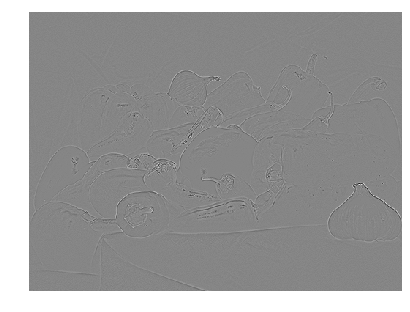

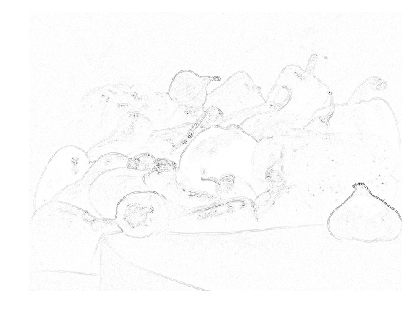

In [9]:
# Manually design a filter
w = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]], 'f')
w = np.tile(w[np.newaxis, np.newaxis, :, :], [3, 1, 1])
y_lap = nnconv()(x4d, w)
plot_v(y_lap[0])
plot_v(-np.abs(y_lap[0]))

## Part 1.2: non-linear gating

As we stated in the introduction, CNNs are obtained by composing several different functions. In addition to the linear filters shown in the previous part, there are several non-linear operators as well.

The simplest non-linearity is obtained by following a linear filter by a *non-linear gating function*, applied identically to each component (i.e. point-wise) of a feature map. The simplest such function is the *Rectified Linear Unit (ReLU)*

\begin{equation}
y_{ijk} = \max\{0, x_{ijk}\}.
\end{equation}


This function can easily be implemented with Theano; let’s try this out:

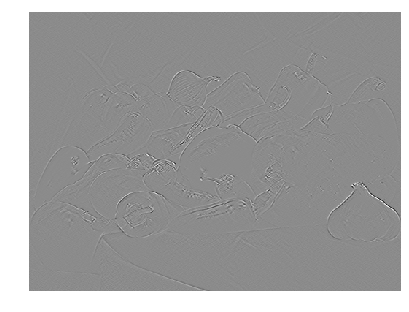

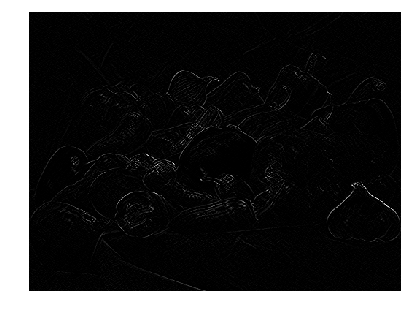

In [10]:
# Define Rectified Linear Unit function with Theano
def relu():
    _x = T.tensor4('input')
    return function([_x], (_x + abs(_x)) / 2.0)

w = np.array([[1, 0, -1], [-1, 0, 1]], 'f')
w = np.tile(w[np.newaxis, np.newaxis, :, :], [3, 1, 1])
y = nnconv()(x4d, w)
z = relu()(y)
plot_v(y[0])
plot_v(z[0])

## Part 1.3: pooling

There are several other important operators in a CNN. One of them is *pooling*. A pooling operator operates on individual feature channels, coalescing nearby feature values into one by the application of a suitable operator. Common choices include max-pooling (using the max operator) or sum-pooling (using summation). For example, *max-pooling* is defined as: 

\begin{equation}
y_{ijk} = \max \{ y_{i'j'k} : i \leq i' < i+p, j \leq j' < j + p \}
\end{equation}

Max pooling is implemented by the $nnpool$ function. Try this now:

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:4: UserWarning: max_pool_2d() will have the parameter ignore_border default value changed to True (currently False). To have consistent behavior with all Theano version, explicitly add the parameter  ignore_border=True. (this is also faster than ignore_border=False)


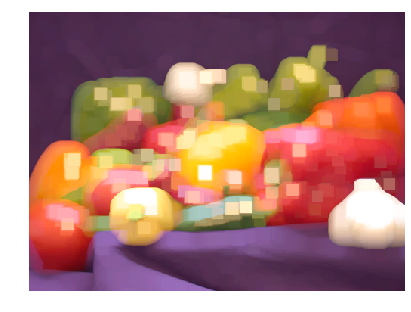

In [11]:
# Define 2d pooling function with Theano
def nnpool(n, stride=1):
    _x = T.tensor4('input')
    ds = downsample.max_pool_2d(_x, (n, n), st=(stride, stride))
    return function([_x], ds)
y = nnpool(15)(x4d)
y_as_image = np.array(y[0].transpose((1, 2, 0)), 'uint8')
plot(y_as_image)

## Part 1.4: normalisation

Another important CNN building block is channel-wise normalisation. This operator normalises the vector of feature channels at each spatial location in the input map $\mathbf x$. The form of the normalisation operator is actually rather curious: 

\begin{equation}
y_{ijk'} = \frac{x_{ijk}}{\left(\kappa + \alpha \sum_{k\in G(k')}  x_{ijk}^2\right)^{\beta}}
\end{equation}

where $G(k) = \left[k - \lfloor \frac{\rho}{2} \rfloor, k + \lceil \frac{\rho}{2} \rceil\right] \cap \{1, 2, \dots, K\}$ is a group of $\rho$ consecutive feature channels in the input map. 

Now let’s try this out:

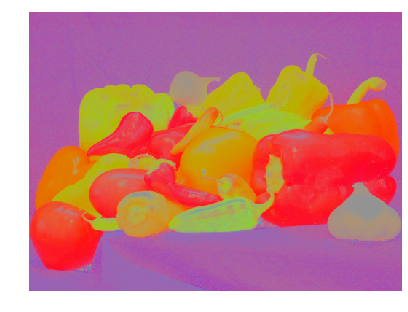

In [12]:
# Define normalization function with Theano
def nnnormalize(rho, kappa, alpha, beta):
    """
    This code is adapted from pylearn2.
    License at: https://github.com/lisa-lab/pylearn2/blob/master/LICENSE.txt
    """
    _x = T.tensor4('input')
    b, ch, r, c = _x.shape
    half_rho = rho // 2
    input_sqr = T.sqr(_x)
    extra_channels = T.alloc(0., b, ch + 2 * half_rho, r, c)
    input_sqr = T.set_subtensor(extra_channels[:, half_rho:half_rho + ch, :, :], input_sqr)
    scale = kappa
    for i in range(rho):
        scale += alpha * input_sqr[:, i:i + ch, :, :]
    scale = scale ** beta
    return function([_x], _x / scale)

y_nrm = nnnormalize(rho=5, kappa=0, alpha=1, beta=0.5)(x4d)
y_as_image = np.array(256 * y_nrm[0].transpose((1, 2, 0)), 'uint8')
plot(y_as_image)